In [ ]:
#!pip install split-folders

### **Importing of Necessary Libraries**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

### **Dataset Loading and Splitting**
Split-folders library was used to split the dataset into three parts: Training set(70%), Validation set(15%), and Test set(15%).

In [3]:
base_ds = 'C:/Users/rames/Desktop/Final_Project/Indian_Dataset'
base_ds = pathlib.Path(base_ds)

In [4]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 5000 files [00:03, 1477.22 files/s]


In [6]:
import os

# Base dataset directory
base_ds = 'imgs/train'

# Define the rice classes
classes = ['Ambemohar', 'Basmati', 'Indrayani', 'Kaalimuch', 'Kolam']

# Initialize rice lists
rice = []
rice_classes = []

# Supported extensions (case-sensitive)
valid_extensions = ['.jpg', '.png', '.jpeg', '.JPG', '.PNG', '.JPEG']

# Iterate through each class folder and collect filenames
for rice_type in classes:
    rice_files = [
        fn for fn in os.listdir(f'{base_ds}/{rice_type}')
        if any(fn.endswith(ext) for ext in valid_extensions)
    ]
    rice.append(rice_files)
    rice_classes.append(rice_type)

# Sort the classes alphabetically for consistency
rice_classes.sort()

# Output the results
print(f"Rice classes: {rice_classes}")
for i, r in enumerate(rice):
    print(f"{rice_classes[i]}: {len(r)} images")


Rice classes: ['Ambemohar', 'Basmati', 'Indrayani', 'Kaalimuch', 'Kolam']
Ambemohar: 700 images
Basmati: 700 images
Indrayani: 700 images
Kaalimuch: 700 images
Kolam: 700 images


### **Dataset Exploration**
It can be seen here the total number of images in the dataset, the number of classes, and how well the images from each variety is distributed

Total images: 3500
Total number of classes: 5

Total Ambemohar images: 700
Total Basmati images: 700
Total Indrayani images: 700
Total Kaalimuch images: 700
Total Kolam images: 700


C:\Users\rames\AppData\Local\Temp\ipykernel_5208\3458000913.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rice_classes, y=rice_count, palette="Blues_d")


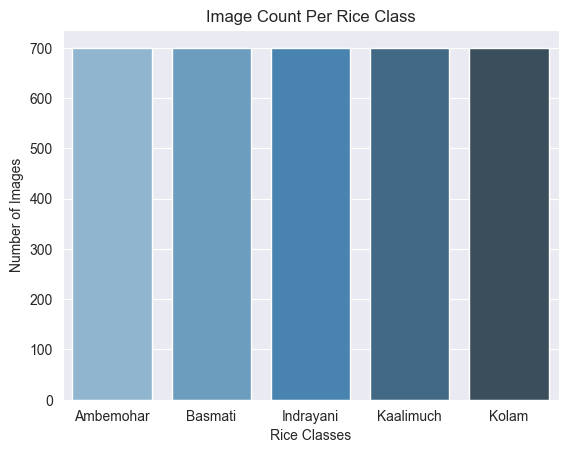

In [8]:
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# Base dataset directory
base_ds = Path('imgs/train')

# Define the rice classes
rice_classes = ['Ambemohar', 'Basmati', 'Indrayani', 'Kaalimuch', 'Kolam']

# Supported extensions (case-sensitive)
valid_extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']

# Count total images across all classes
image_count = sum(
    1 for file in base_ds.glob('*/*') if any(file.suffix == ext for ext in valid_extensions)
)
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(rice_classes)}\n')

# Count images per class
rice_count = []
for rice_type in rice_classes:
    rice_path = base_ds / rice_type
    count = sum(
        1 for file in rice_path.glob('*') if any(file.suffix == ext for ext in valid_extensions)
    )
    rice_count.append(count)
    print(f'Total {rice_type} images: {count}')

# Visualize the image count per class using Seaborn
sns.set_style('darkgrid')
sns.barplot(x=rice_classes, y=rice_count, palette="Blues_d")
plt.xlabel('Rice Classes')
plt.ylabel('Number of Images')
plt.title('Image Count Per Rice Class')
plt.show()


### Sample Images
Each image from the dataset has a dimension of 250 by 250 and a color type of RGB

Image dimensions: (255, 255, 3)


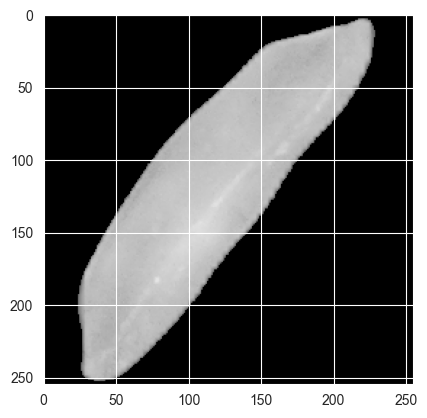

In [9]:
sample_img = cv2.imread('C:/Users/rames/Desktop/Final_Project/imgs/test/Kaalimuch/Kaalimuch (870).png')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [10]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in rice_classes:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

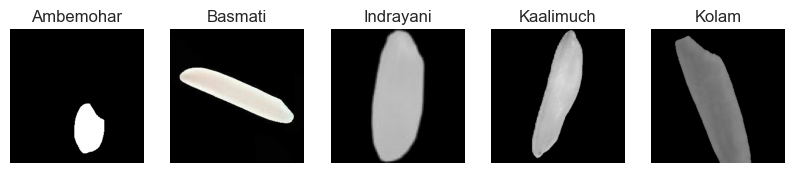

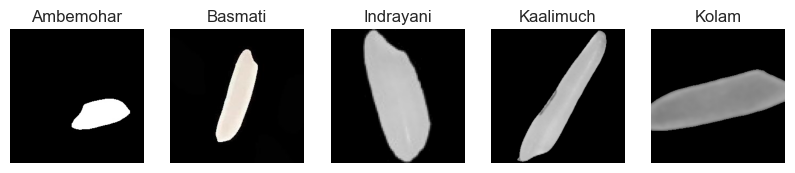

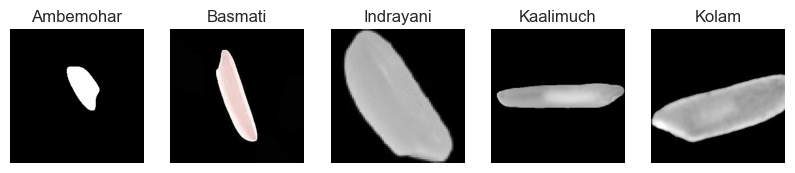

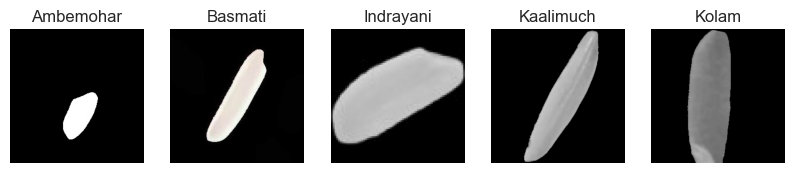

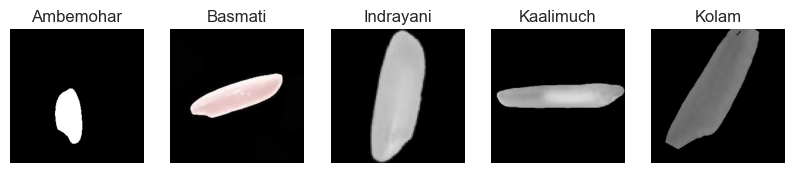

In [11]:
for i in range(5):
  load_random_img(base_ds, rice_classes)

In [12]:
batch_size = 128
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)

### **Data Pre-processing**

In [13]:
datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=20,           # Randomly rotate images by 20 degrees
    width_shift_range=0.2,       # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,      # Randomly shift images vertically by 20% of the height
    shear_range=0.2,             # Shear transformations
    zoom_range=0.2,              # Random zoom within 20%
    horizontal_flip=True,        # Flip images horizontally
    fill_mode='nearest'          # Fill pixels that are shifted using the nearest pixel value
)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Validation and test data generator without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training dataset
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  # Shuffle for training
)

# Validation dataset
val_ds = val_datagen.flow_from_directory(
    'imgs/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No shuffling for validation
)

# Test dataset
test_ds = test_datagen.flow_from_directory(
    'imgs/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No shuffling for testing
)


Found 3500 images belonging to 5 classes.
Found 750 images belonging to 5 classes.
Found 750 images belonging to 5 classes.


In [17]:
import matplotlib.pyplot as plt

def plot_train_history(history):
    # Ensure history contains 'accuracy' and 'loss'
    if 'accuracy' not in history.history or 'loss' not in history.history:
        print("Error: The history object does not contain 'accuracy' or 'loss'. Check the training process.")
        return

    plt.figure(figsize=(15, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='o')
    plt.title('Model Accuracy', fontsize=14)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='red', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='green', marker='o')
    plt.title('Model Loss', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## **Vanilla CNN Model**

In [18]:
model_vanilla = tf.keras.Sequential([
    # First Convolution Block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    tf.keras.layers.Dropout(0.25),  # Slightly reduced dropout

    # Second Convolution Block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    tf.keras.layers.Dropout(0.3),  # Reduced to align with earlier block

    # Third Convolution Block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    tf.keras.layers.Dropout(0.4),  # Increased slightly for deeper block

    # Flatten and Fully Connected Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),  # Reduced neurons to prevent overfitting
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),  # Balanced dropout

    # Output Layer
    tf.keras.layers.Dense(5, activation='softmax')
])


c:\Users\rames\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model_vanilla.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Explicitly set learning rate
    loss='categorical_crossentropy', 
    metrics=['accuracy', 'AUC']  # Added AUC for better evaluation
)

# Display model architecture summary
model_vanilla.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 111, 111, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 111, 111, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 111, 111, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 111, 111, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,014,245 (99.24 MB)

 Trainable params: 26,012,581 (99.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

## **Callbacks**

In [21]:
# Create directory for saving models if it doesn't exist
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Define the checkpoint callback to save the best model based on validation accuracy
checkpointer = ModelCheckpoint(
    filepath=os.path.join(models_dir, 'model_vanilla_best.keras'),  # Use dynamic path
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

# Early stopping callback to stop training if validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=5  # Increased patience for more flexibility
)

# Learning rate reduction callback to decrease the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=3,  # Increased patience for gradual learning rate decay
    min_lr=0.0001  # Reduced minimum learning rate for finer adjustments
)

# Combine all callbacks into a list
callbacks = [early_stopping, reduce_lr, checkpointer]


In [22]:
# Train the model with callbacks
history1 = model_vanilla.fit(
    train_ds,
    epochs=40,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=2  # Optionally control the verbosity for cleaner output
)

c:\Users\rames\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40

Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to saved_models\model_vanilla_best.keras
28/28 - 200s - 7s/step - AUC: 0.9398 - accuracy: 0.7429 - loss: 0.7077 - val_AUC: 0.5976 - val_accuracy: 0.2000 - val_loss: 4.7190 - learning_rate: 0.0010
Epoch 2/40

Epoch 2: val_accuracy improved from 0.20000 to 0.27200, saving model to saved_models\model_vanilla_best.keras
28/28 - 177s - 6s/step - AUC: 0.9961 - accuracy: 0.9514 - loss: 0.1552 - val_AUC: 0.5370 - val_accuracy: 0.2720 - val_loss: 5.2172 - learning_rate: 0.0010
Epoch 3/40

Epoch 3: val_accuracy did not improve from 0.27200
28/28 - 178s - 6s/step - AUC: 0.9974 - accuracy: 0.9609 - loss: 0.1183 - val_AUC: 0.5239 - val_accuracy: 0.2000 - val_loss: 6.0254 - learning_rate: 0.0010
Epoch 4/40

Epoch 4: val_accuracy did not improve from 0.27200
28/28 - 174s - 6s/step - AUC: 0.9988 - accuracy: 0.9649 - loss: 0.0937 - val_AUC: 0.4687 - val_accuracy: 0.2000 - val_loss: 7.4168 - learning_rate: 0.0010
Epoch 5/40

E

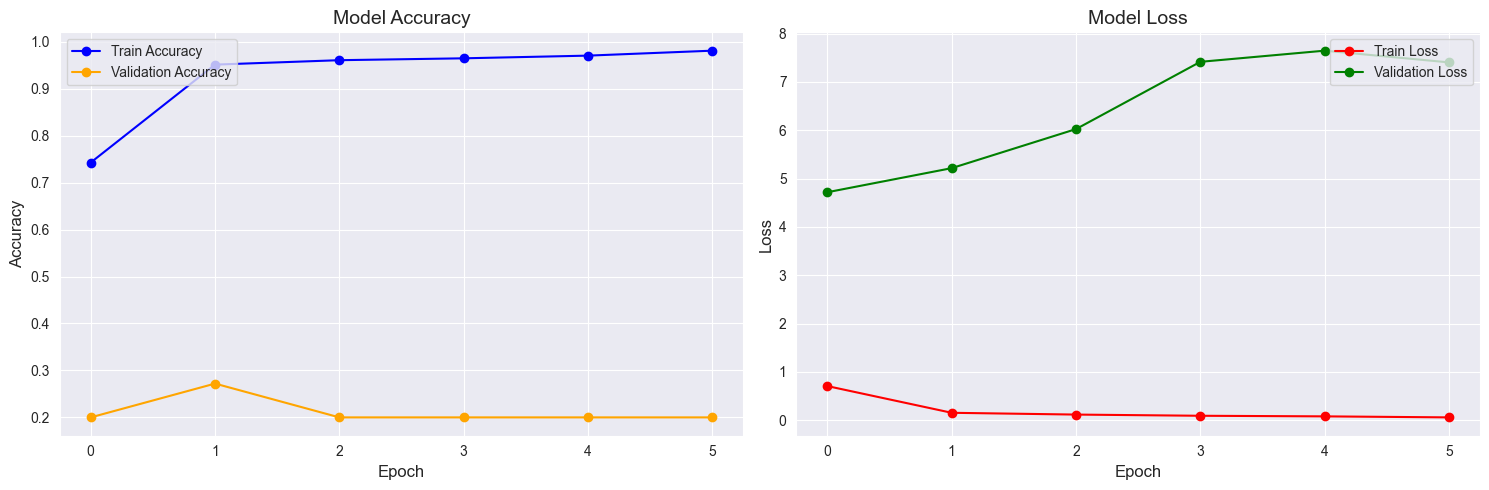

In [24]:
model_vanilla.load_weights('saved_models/model_vanilla_best.keras')
plot_train_history(history1)

## **Model Evaluation of Vanilla CNN**

In [28]:
score1 = model_vanilla.evaluate(test_ds, verbose=1)
loss = score1[0]
accuracy = score1[1]
auc = score1[2]  # AUC would be the third element if included as a metric
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test AUC: {auc}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - AUC: 0.4244 - accuracy: 0.1902 - loss: 5.9793
Test Loss: 5.210506916046143
Test Accuracy: 0.2786666750907898
Test AUC: 0.5370491147041321


In [20]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model_vanilla.predict(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


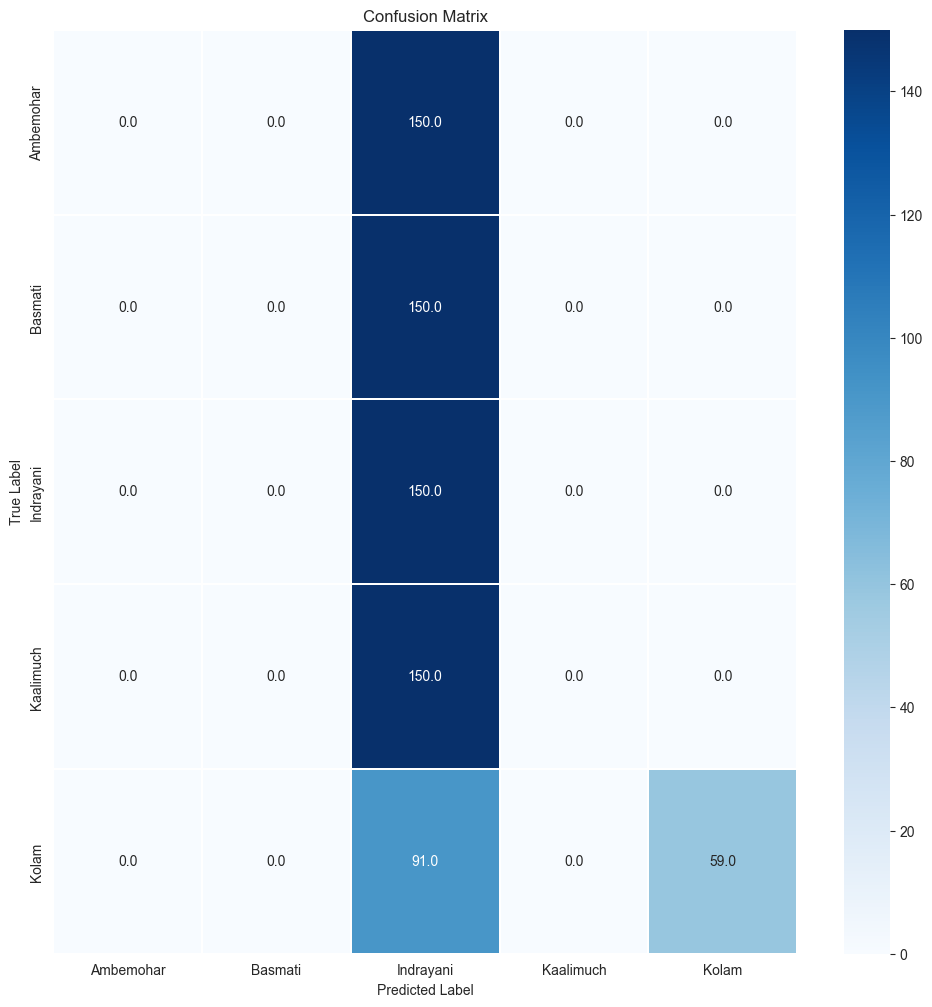

              precision    recall  f1-score   support

   Ambemohar       0.00      0.00      0.00       150
     Basmati       0.00      0.00      0.00       150
   Indrayani       0.22      1.00      0.36       150
   Kaalimuch       0.00      0.00      0.00       150
       Kolam       1.00      0.39      0.56       150

    accuracy                           0.28       750
   macro avg       0.24      0.28      0.18       750
weighted avg       0.24      0.28      0.18       750



c:\Users\rames\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rames\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rames\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the test dataset
Y_pred = model_vanilla.predict(test_ds, verbose=1)  # Add verbose=1 to track progress
y_pred = np.argmax(Y_pred, axis=1)  # Get predicted class indices

# True labels
y_true = test_ds.classes  # True labels

# Confusion Matrix
confusion_mtx = confusion_matrix(y_true, y_pred)  # True labels vs predicted labels

# Plot confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt='.1f', ax=ax, cmap="Blues")  # Change color palette to 'Blues' for better contrast

# Set labels and titles
ax.xaxis.set_ticklabels(test_ds.class_indices.keys())  # X-axis: predicted labels
ax.yaxis.set_ticklabels(rice_classes)  # Y-axis: true labels (adjust with rice_classes if needed)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Optional: print classification report
print(classification_report(y_true, y_pred, target_names=rice_classes))


In [31]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report (output_dict=True returns the report as a dictionary)
report1 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)

# Convert the dictionary into a pandas DataFrame for better visualization
df1 = pd.DataFrame(report1).transpose()

# Display the classification report DataFrame
print(df1)


              precision    recall  f1-score     support
Ambemohar      0.000000  0.000000  0.000000  150.000000
Basmati        0.000000  0.000000  0.000000  150.000000
Indrayani      0.217077  1.000000  0.356718  150.000000
Kaalimuch      0.000000  0.000000  0.000000  150.000000
Kolam          1.000000  0.393333  0.564593  150.000000
accuracy       0.278667  0.278667  0.278667    0.278667
macro avg      0.243415  0.278667  0.184262  750.000000
weighted avg   0.243415  0.278667  0.184262  750.000000


c:\Users\rames\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rames\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rames\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## **Transfer Learning**

In [32]:
from tensorflow.keras.applications import VGG16
import tensorflow as tf

# Load VGG16 with pre-trained ImageNet weights, without the top layers
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

# Freeze the VGG16 layers to prevent them from being trained
vgg16.trainable = False

# Define the input layer
inputs = tf.keras.Input(input_shape)

# Pass the input through the pre-trained VGG16 base model
x = vgg16(inputs, training=False)

# Apply Global Average Pooling to reduce the spatial dimensions
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Fully connected layer (Dense layer) with 1024 units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)

# Output layer with 5 units for classification and softmax activation
x = tf.keras.layers.Dense(5, activation='softmax')(x)

# Create the final model with the input and output layers
model_vgg16 = tf.keras.Model(inputs, x)

# Compile the model (you can adjust the optimizer and loss function as needed)
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary to confirm the architecture
model_vgg16.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,245,125 (58.16 MB)

 Trainable params: 530,437 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [34]:
# Ensure the directory for saving models exists
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Define the checkpoint callback to save the best model based on validation accuracy
checkpointer = ModelCheckpoint(
    filepath=os.path.join(models_dir, 'model_vgg16.keras'),  # Dynamic path
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

# Early stopping callback to stop training if validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=3  # Early stop after 3 epochs without improvement
)

# Learning rate reduction callback to decrease the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=2,  # Wait for 2 epochs before reducing LR
    min_lr=0.001  # Set a minimum learning rate to avoid too small steps
)

# Combine all callbacks into a list
callbacks = [early_stopping, reduce_lr, checkpointer]

# Train the model
history2 = model_vgg16.fit(
    train_ds, 
    epochs=40, 
    validation_data=val_ds, 
    callbacks=callbacks
)


Epoch 1/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5123 - loss: 1.2961
Epoch 1: val_accuracy improved from -inf to 0.87067, saving model to saved_models\model_vgg16.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 204s 7s/step - accuracy: 0.5177 - loss: 1.2877 - val_accuracy: 0.8707 - val_loss: 0.5637 - learning_rate: 0.0010
Epoch 2/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8778 - loss: 0.5660
Epoch 2: val_accuracy improved from 0.87067 to 0.95067, saving model to saved_models\model_vgg16.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 204s 7s/step - accuracy: 0.8781 - loss: 0.5639 - val_accuracy: 0.9507 - val_loss: 0.3090 - learning_rate: 0.0010
Epoch 3/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9055 - loss: 0.3653
Epoch 3: val_accuracy improved from 0.95067 to 0.96000, saving model to saved_models\model_vgg16.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 225s 8s/step - accuracy: 0.9055 - loss: 0.3647 - val_accuracy: 0.9600 - val_loss: 0.2172 - learning_rate: 0.0010
Epoch 4/40
28/28 ━━━━━━━━

In [35]:
model_vgg16.load_weights('saved_models/model_vgg16.keras')

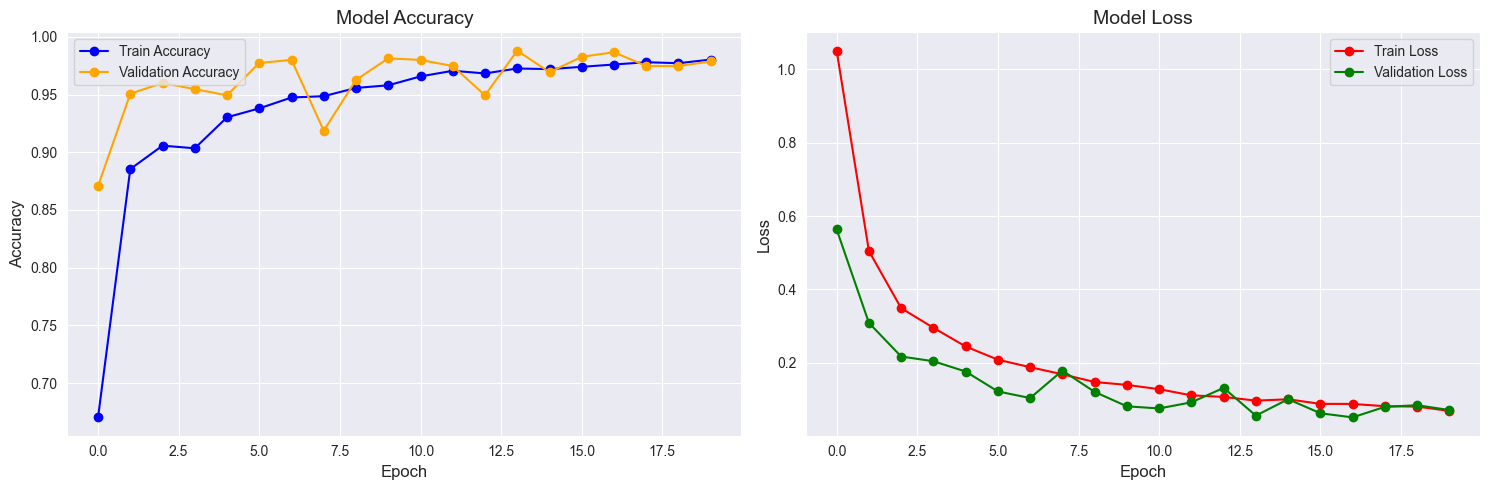

In [36]:
plot_train_history(history2)

In [38]:
# Evaluate Model 1 (Vanilla CNN)
score1 = model_vanilla.evaluate(test_ds, verbose=1)
print(f'Model 1 Vanilla CNN Loss: {score1[0]}, Accuracy: {score1[1] * 100:.2f}%')

# Evaluate Model 2 (VGG16)
score2 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1] * 100:.2f}%')


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 914ms/step - AUC: 0.4244 - accuracy: 0.1902 - loss: 5.9793
Model 1 Vanilla CNN Loss: 5.210506916046143, Accuracy: 27.87%
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.9905 - loss: 0.0342
Model 2 VGG16 Loss: 0.06640643626451492, Accuracy: 98.27%


## **Fine Tuning**

In [39]:
# Unfreeze the top layers for fine-tuning
for layer in vgg16.layers[:15]:  # Freeze the first 15 layers (or choose appropriate layers)
    layer.trainable = False
for layer in vgg16.layers[15:]:  # Unfreeze the remaining layers
    layer.trainable = True

# Recompile the model with a smaller learning rate
model_vgg16.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# Fine-tuning the model
history3 = model_vgg16.fit(train_ds, epochs=40, validation_data=val_ds, callbacks=callbacks)


Epoch 1/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9767 - loss: 0.0803
Epoch 1: val_accuracy did not improve from 0.98800
28/28 ━━━━━━━━━━━━━━━━━━━━ 160s 6s/step - accuracy: 0.9766 - loss: 0.0802 - val_accuracy: 0.9840 - val_loss: 0.0508 - learning_rate: 1.0000e-05
Epoch 2/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9888 - loss: 0.0469
Epoch 2: val_accuracy did not improve from 0.98800
28/28 ━━━━━━━━━━━━━━━━━━━━ 159s 6s/step - accuracy: 0.9888 - loss: 0.0468 - val_accuracy: 0.9853 - val_loss: 0.0395 - learning_rate: 1.0000e-05
Epoch 3/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9886 - loss: 0.0405
Epoch 3: val_accuracy did not improve from 0.98800
28/28 ━━━━━━━━━━━━━━━━━━━━ 159s 6s/step - accuracy: 0.9887 - loss: 0.0405 - val_accuracy: 0.9853 - val_loss: 0.0372 - learning_rate: 1.0000e-05
Epoch 4/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9916 - loss: 0.0319
Epoch 4: val_accuracy improved from 0.98800 to 0.98933, saving model to saved_model

In [40]:
model_vgg16.load_weights('saved_models/model_vgg16.keras')

## **Final Evaluation**

In [58]:
# Evaluate the fine-tuned VGG16 model
score3 = model_vgg16.evaluate(test_ds, verbose=1)

# Print the evaluation results for all three models
print(f'Model 1 Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')
print(f'Model 2 VGG16 Fine-tuned Loss: {score3[0]}, Accuracy: {score3[1]*100}')


6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.9937 - loss: 0.0149
Model 1 Vanilla Loss: 5.210506916046143, Accuracy: 27.86666750907898
Model 2 VGG16 Loss: 0.06640643626451492, Accuracy: 98.26666712760925
Model 2 VGG16 Fine-tuned Loss: 0.021441854536533356, Accuracy: 99.19999837875366


In [59]:
Y_pred = model_vgg16.predict(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step


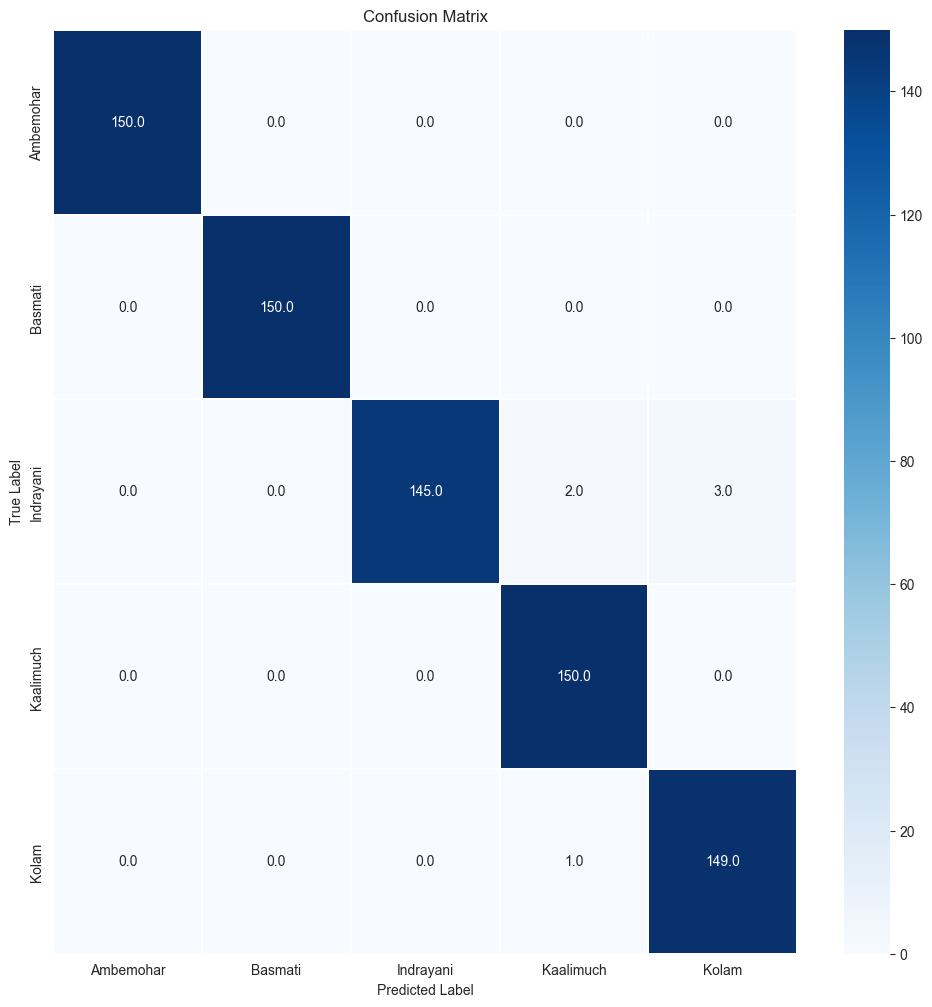

In [60]:
import matplotlib.pyplot as plt

# Get the true labels and predicted labels
y_true = test_ds.classes
y_pred = np.argmax(Y_pred, axis=1)

# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Create the plot
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt='.1f', ax=ax, cmap='Blues')

# Set axis labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices.keys())  # Class names for x-axis
ax.yaxis.set_ticklabels(rice_classes)  # Your rice class names for y-axis
plt.title("Confusion Matrix")
plt.show()


In [61]:
report2 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

,precision,recall,f1-score,support
Ambemohar,1.000000,1.000000,1.000000,150.000
Basmati,1.000000,1.000000,1.000000,150.000
Indrayani,1.000000,0.966667,0.983051,150.000
Kaalimuch,0.980392,1.000000,0.990099,150.000
Kolam,0.980263,0.993333,0.986755,150.000
accuracy,0.992000,0.992000,0.992000,0.992
macro avg,0.992131,0.992000,0.991981,750.000
weighted avg,0.992131,0.992000,0.991981,750.000


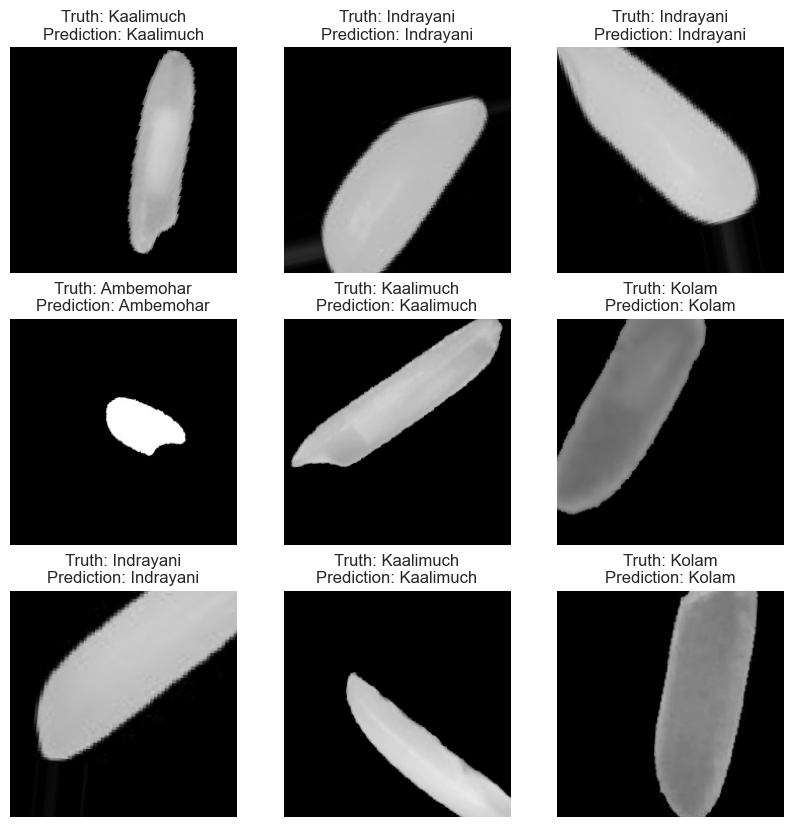

In [63]:
plt.figure(figsize=(10, 10))

# Get the first batch of images and labels
x, label = next(train_ds)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    
    # Get the ground truth label
    result = np.where(label[i] == 1)
    
    # Make predictions using the model
    predict = model_vgg16(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = rice_classes[np.argmax(score)]
    
    # Plot title with truth and predicted label
    plt.title(f'Truth: {rice_classes[result[0][0]]}\nPrediction: {score_label}')
    plt.axis(False)

plt.show()


In [64]:
model_vgg16

<Functional name=functional_1, built=True>

In [65]:

# Convert the model to a TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_vgg16)
tflite_model = converter.convert()

# Apply post-training quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Save the quantized model to a file
with open('model_vgg16_quant.tflite', 'wb') as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\rames\AppData\Local\Temp\tmpijk05q0w\assets


INFO:tensorflow:Assets written to: C:\Users\rames\AppData\Local\Temp\tmpijk05q0w\assets


Saved artifact at 'C:\Users\rames\AppData\Local\Temp\tmpijk05q0w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_46')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  1937346312528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1937346310992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1937346313104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938076845264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938076845456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938076846032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938076846224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938076846800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938076846992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938076847568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19

INFO:tensorflow:Assets written to: C:\Users\rames\AppData\Local\Temp\tmpyyp3pbqc\assets


Saved artifact at 'C:\Users\rames\AppData\Local\Temp\tmpyyp3pbqc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_46')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  1937346312528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1937346310992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1937346313104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938076845264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938076845456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938076846032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938076846224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938076846800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938076846992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1938076847568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19

In [66]:
from keras.models import load_model

# Assuming you have a trained Keras model called "model"
# Save the model
model_vgg16.save('rice_image_classification_.keras')